In [6]:
%load_ext autoreload
%autoreload 2
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
from scipy.signal import argrelextrema

from standes.analysis.recorders import get_recorders, get_recorder 
from standes.analysis.ida import process_ida_results
from standes.fragility_curves import FragilityCurve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# folders
ROOT = Path("E:/01_model_verification_analyses/damping_model")

model_folders =  {
    "rayleigh": "3s_cbf_dc2_41_rayleigh_initial",
    "const. modal": "3s_cbf_dc2_41_modal_12",
    "upd. modal": "3s_cbf_dc2_41_modal_12_updating",
    }

record_folders = {
    "0.5": "nltha_120621_sf0500",
    "2.0": "nltha_120621_sf2000", 
    "2.75":"nltha_120621_sf2750", 
    "3.5": "nltha_120621_sf3500"
    }

FIGURE_DST = Path("C:/Users/clemettn/OneDrive - Helmut-Schmidt-Universität/01_arbeit/14_PhD/images/damping_verification")

# other info
building_height = 10500
storey_masses = [107889.9082568807, 107889.9082568807, 96330.2752293578]  # in kg and starting from 1 floor above ground
building_weight = sum(storey_masses) * 9.810     # N


In [175]:
# Load data and do some post processing
model_results = {}
for model_tag, model_folder in model_folders.items():
    record_results = {}
    for record_tag, record_folder in record_folders.items():
        results_folder = ROOT / model_folder / record_folder
        temp = {}
        with open(results_folder / "recorders.pickle", "rb") as file:
            temp["recorders"] = pickle.load(file)
        with open(results_folder / "collapserecorders.pickle", "rb") as file:
            temp["collapserecorders"] = pickle.load(file)
        with open(results_folder / "timearray.pickle", "rb") as file:
            temp["time"] = np.array(pickle.load(file))
        with open(results_folder / "collapse.json", "r") as file:
            data = json.load(file)
        temp = temp | data
        temp["nodal_masses"] = {int(k):v for k, v in temp["nodal_masses"].items()}
        
        record_results[record_tag] = temp
    model_results[model_tag] = record_results

In [176]:
# Process data and calculate the storey damping forces
model_responses = {}
for model_tag, mr in model_results.items():
    record_responses = {}
    for record_tag, rr in mr.items():
        record_response = {}
        # storey structural force history
        vs_responses = {}
        for ii in range(1,4):
            vs_recorder = get_recorder(rr["recorders"], "storey_shear", ii, 1)
            vs_responses[ii] = -np.array(vs_recorder.record[1])
            # negative of vs because we want the force acting on the nodes for the equilibrium. 
            # The globalforce command used to calculate storey shears if the force acting on the element
            # which needs to be inverted to give the force acting on the nodes

        # storey inertial force history
        fi_responses = {}
        acc_responses = {}
        # acceleration history
        for level_jj in range(2,5):
            acc = {}
            sum_acc = np.array(0.0)
            storey_inertial_force = np.array(0.0)
            for col_ii in range(1, 5):
                node_tag = int(f"10{col_ii}010{level_jj}00")
                acc_recorder_tag = f"{node_tag}_[1]"
                acc_recorder = get_recorder(rr["recorders"], "node_acceleration", acc_recorder_tag)
                acc_response = np.array(acc_recorder.record[1])
                acc[node_tag] = acc_response
                sum_acc = sum_acc +  acc_response
                storey_inertial_force = storey_inertial_force + acc_response * rr["nodal_masses"][node_tag]     # in Newtons
        
            fi_responses[level_jj-1] = storey_inertial_force   # in Newtons  
            acc["mean"] = sum_acc / len(acc.keys())
            acc_responses[level_jj-1] = acc

        # cumulative inertial force history
        cfi_responses = {}
        first_array = list(fi_responses.values())[0]
        cumulative = np.zeros_like(first_array)
        
        for ii in reversed(list(fi_responses.keys())):
            cumulative = cumulative + np.array(fi_responses[ii])
            cfi_responses[ii] = cumulative.copy()
        
        cfi_responses = {k: cfi_responses[k] for k in fi_responses.keys()}  # Reverse back so keys remain in original order

        # storey velocity
        vel_responses = {}
        for level_jj in range(2,5):
            vel = {}
            sum_vel = np.array(0.0)
            for col_ii in range(1, 5):
                node_tag = int(f"10{col_ii}010{level_jj}00")
                vel_recorder = get_recorder(rr["recorders"], "node_velocity", node_tag)
                vel_response = np.array(vel_recorder.record[1])
                vel[node_tag] = vel_response
                sum_vel = sum_vel +  vel_response
            
            vel["mean"] = sum_vel / len(vel.keys())
            vel_responses[level_jj-1] = vel

        # storey damping force history
        vd_responses = {}
        for ii, (vmc, vs) in enumerate(zip(cfi_responses.values(), vs_responses.values())):
            vd_responses[ii+1] = -vs - vmc    
            
        # storey drift
        drift_responses = {}
        for ii in range(2,5):
            drift_recorder_tag = int(f"101010{ii}00")
            drift_recorder = get_recorder(rr["recorders"], "drift", drift_recorder_tag)
            drift_responses[ii-1] = np.array(drift_recorder.record[1])

        # storey displacement
        disp_responses = {}
        for ii in range(2,5):
            disp_recorder_tag = int(f"101010{ii}00")
            disp_recorder = get_recorder(rr["recorders"], "node_displacement", disp_recorder_tag)
            disp_responses[ii-1] = np.array(disp_recorder.record[1])

        # brace axial forces
        left_brace_responses = {}
        right_brace_responses = {}
        for ii in range(1,4):
            member_tag = int(f"401010{ii}01")
            section_recorder_tag = f"{member_tag}_1"
            section_force_recorder = get_recorder(rr["recorders"], "section_force", section_recorder_tag)
            left_brace_responses[ii] = np.array(section_force_recorder.record["P"])

            member_tag = int(f"403010{ii}08")
            section_recorder_tag = f"{member_tag}_5"
            section_force_recorder = get_recorder(rr["recorders"], "section_force", section_recorder_tag)
            right_brace_responses[ii] = np.array(section_force_recorder.record["P"])

        record_response["vs"] = vs_responses
        record_response["fi"] = fi_responses
        record_response["cfi"] = cfi_responses
        record_response["vd"] = vd_responses
        record_response["drift"] = drift_responses
        record_response["disp"] = disp_responses
        record_response["vel"] = vel_responses
        record_response["acc"] = acc_responses
        record_response["Vb_l"] = left_brace_responses
        record_response["Vb_r"] = right_brace_responses
        
        record_responses[record_tag] = rr | record_response
    model_responses[model_tag] = record_responses

## Comparison of Roof displacement histories for each scaled record

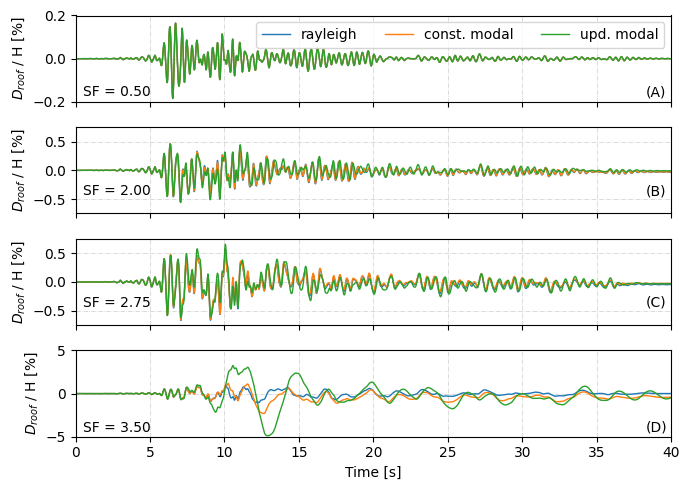

In [182]:
fig, axs = plt.subplots(4, sharex=True, figsize=(7, 5))
y_lim = 2

# plot the record responses for the different scaling factors
for model_tag, mr in model_responses.items():
    for ii, (record_tag, rr) in enumerate(mr.items()):
        axs[ii].plot(rr["time"], np.array(rr["disp"][3]) / building_height * 100, label=f"{model_tag}", lw=1)

axs[0].set_xlim(0,40)
axs[0].legend(ncols=3)
for ax, sf, letter in zip(axs[:1], [0.5], ["A"]):
    ax.set_ylim(-0.2, 0.2)
    ax.grid(True, which="major", ls="-.", color="0.8", linewidth="0.5")
    ax.annotate(f"({letter})", (38.3, -0.175))
    ax.annotate(f"SF = {sf:.2f}", (0.5, -0.175))
    ax.set_ylabel("$D_{roof}$ / H [%]")

for ax, sf, letter in zip(axs[1:3], [2.00, 2.75], ["B", "C"]):
    ax.set_ylim(-0.75, 0.75)
    ax.grid(True, which="major", ls="-.", color="0.8", linewidth="0.5")
    ax.annotate(f"({letter})", (38.3, -0.43))
    ax.annotate(f"SF = {sf:.2f}", (0.5, -0.43))
    ax.set_ylabel("$D_{roof}$ / H [%]")

for ax, sf, letter in zip(axs[3:], [3.5], ["D"]):
    ax.set_ylim(-5.0, 5.0)
    ax.grid(True, which="major", ls="-.", color="0.8", linewidth="0.5")
    ax.annotate(f"({letter})", (38.3, -4.4))
    ax.annotate(f"SF = {sf:.2f}", (0.5, -4.4))
    ax.set_ylabel("$D_{roof}$ / H [%]")

axs[3].set_xlabel("Time [s]")
fig.tight_layout()

fig.savefig(FIGURE_DST / "roof_displacement_comparison.png", dpi=300)

In [189]:
# print the maximum roof displacements

string = f"{'Model':<20}|{'SF = 0.50':^10}|{'SF = 2.00':^10}{'SF = 2.75':^10}|{'SF = 3.50':^10}\n{'-'*65}\n"
for model_tag, mr in model_responses.items():
    string += f"{model_tag:<20}"
    for ii, (record_tag, rr) in enumerate(mr.items()):
        string += f"|{max(np.abs(rr["disp"][3]))/ building_height * 100:^10.2f}" 
    string += "\n"
string += f"{'-'*65}\n"

print(string)


Model               |SF = 0.50 |SF = 2.00 SF = 2.75 |SF = 3.50 
-----------------------------------------------------------------
rayleigh            |   0.18   |   0.55   |   0.67   |   1.05   
const. modal        |   0.18   |   0.55   |   0.65   |   2.32   
upd. modal          |   0.18   |   0.56   |   0.65   |   4.88   
-----------------------------------------------------------------



## Comparison of Storey Damping Forces

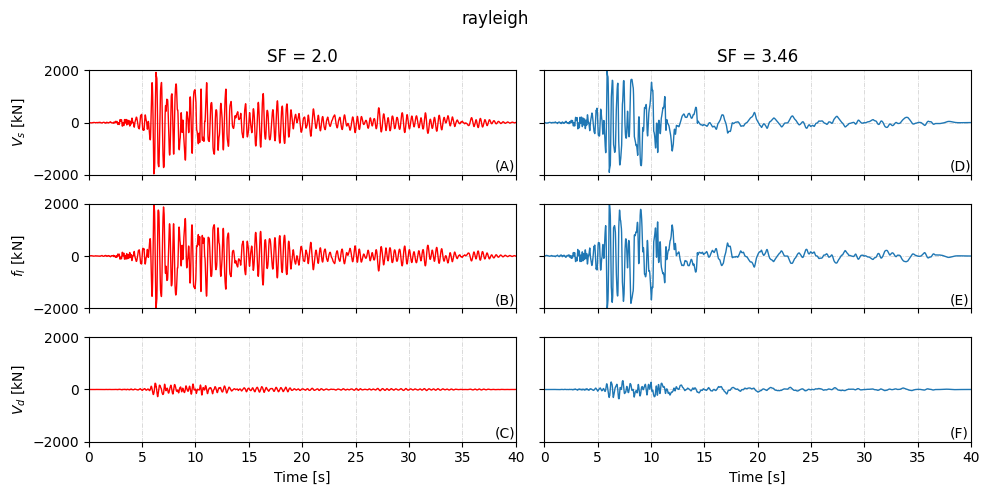

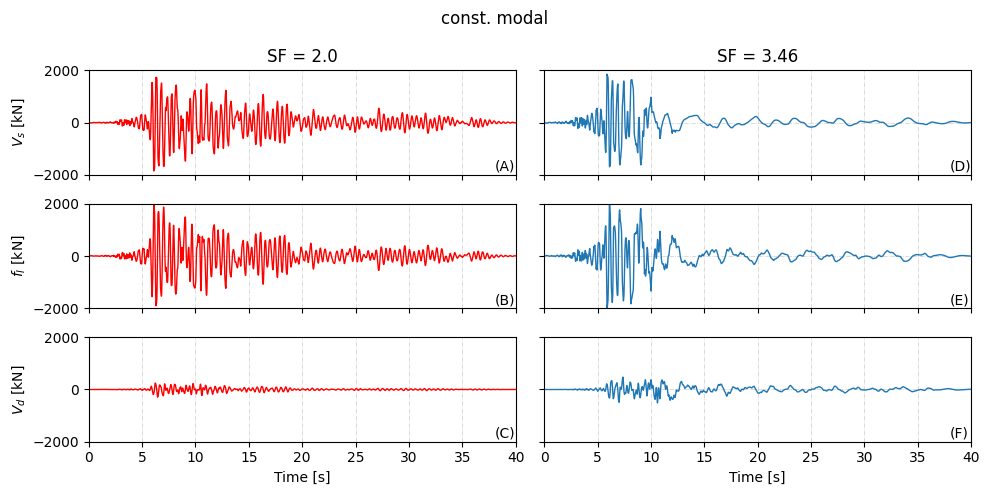

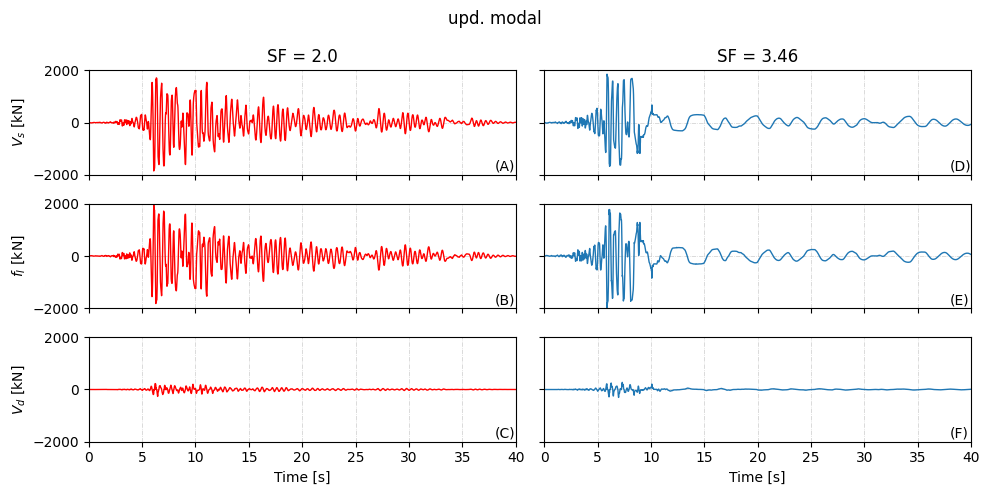

In [193]:
for model_tag, mr in model_responses.items():

    fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10, 5))

    y_lim = 2000
    # plot storey force histories
    storey = 1

    rr = mr["2.0"]
    axs[0,0].plot(rr["time"], np.array(rr["vs"][storey]) / 1000, color="r", lw=1) # kN --> negative because I want to show the force on the nodes
    axs[1,0].plot(rr["time"], np.array(rr["cfi"][storey]) / 1000, color="r", lw=1) # kN
    axs[2,0].plot(rr["time"], np.array(rr["vd"][storey]) / 1000, color="r", lw=1) # kN

    rr = mr["3.5"]
    axs[0,1].plot(rr["time"], np.array(rr["vs"][storey]) / 1000, lw=1) # kN --> negative because I want to show the force on the nodes
    axs[1,1].plot(rr["time"], np.array(rr["cfi"][storey]) / 1000, lw=1) # kN
    axs[2,1].plot(rr["time"], np.array(rr["vd"][storey]) / 1000, lw=1) # kN

    axs_o = [axs[0,0], axs[1,0], axs[2,0], axs[0,1], axs[1,1], axs[2,1]]

    for ax, letter in zip(axs_o, ["A", "B", "C", "D", "E", "F"]):
        ax.grid(True, which="major", ls="-.", color="0.8", linewidth="0.5")
        ax.set_ylim(-y_lim, y_lim)
        ax.annotate(f"({letter})", (38, -1850))

    fig.suptitle(f"{model_tag}")
    axs_o[0].set_xlim(0,40)
    axs_o[0].set_ylabel("$V_s$ [kN]")
    axs_o[0].set_title("SF = 2.0")
    axs_o[1].set_ylabel("$f_{I}$ [kN]")
    axs_o[2].set_ylabel("$V_d$ [kN]")
    axs_o[2].set_xlabel("Time [s]")
    axs_o[3].set_title("SF = 3.46")
    axs_o[5].set_xlabel("Time [s]")
    fig.tight_layout()

    fig.savefig(FIGURE_DST / f"ground_floor_storey_force_histories_{model_tag}.png", dpi=300)


Comparison of roof displacements and damping forces

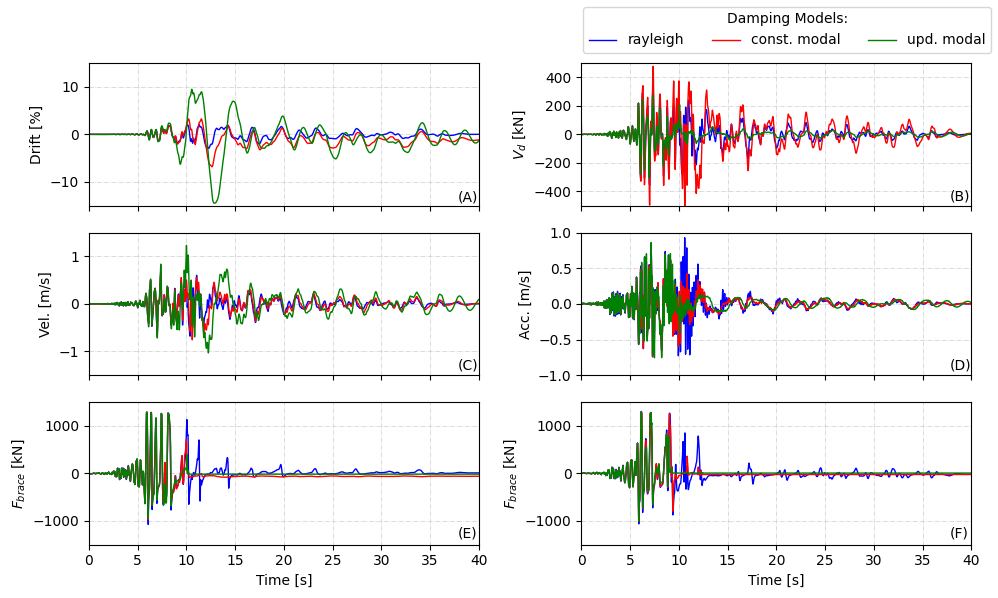

In [225]:
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(10, 6))
axs = axs.flatten()

colours = ["b", "r", "g"]

for model_tag, colour in zip(list(model_responses.keys()), colours):
    mr = model_responses[model_tag]["3.5"]
    axs[0].plot(mr["time"], mr["drift"][1] * 100, color=colour, lw=1, label=f"{model_tag}")
    axs[1].plot(mr["time"], mr["vd"][1] / 1000, color=colour, lw=1) # kN
    axs[2].plot(mr["time"], mr["vel"][1]["mean"] / 1000, color=colour, lw=1) # m/s
    axs[3].plot(mr["time"], mr["acc"][1]["mean"] / 9810, color=colour, lw=1) # g
    axs[4].plot(mr["time"], mr["Vb_l"][1] / 1000, color=colour, lw=1) # left brace force kN
    axs[5].plot(mr["time"], mr["Vb_r"][1] / 1000, color=colour, lw=1) # right brace force kN

for ax in axs.flatten():
    ax.grid(True, which="major", ls="-.", color="0.8", linewidth="0.5")

# fig.suptitle("Roof Displacments and Damping Forces")
axs[0].set_xlim(0,40)
axs[0].set_ylabel("Drift [%]")
axs[0].set_ylim(-15, 15)
axs[0].annotate(f"(A)", (37.8, -14))

axs[1].set_ylabel("$V_d$ [kN]")
axs[1].set_ylim(-500, 500)
axs[1].annotate(f"(B)", (37.8, -460))

axs[2].set_ylabel("Vel. [m/s]")
axs[2].set_ylim(-1.5, 1.5)
axs[2].annotate(f"(C)", (37.8, -1.38))


axs[3].set_ylabel("Acc. [m/s]")
axs[3].set_ylim(-1, 1)
axs[3].annotate(f"(D)", (37.8, -0.92))

axs[4].set_ylabel("$F_{brace}$ [kN]")
axs[4].set_ylim(-1500, 1500)
axs[4].annotate(f"(E)", (37.8, -1350))
axs[4].set_xlabel("Time [s]")

axs[5].set_ylabel("$F_{brace}$ [kN]")
axs[5].set_ylim(-1500, 1500)
axs[5].annotate(f"(F)", (37.8, -1350))
axs[5].set_xlabel("Time [s]")

fig.tight_layout()
h, l = axs[0].get_legend_handles_labels()
fig.legend(h,l,loc="outside upper right", ncols=3, title="Damping Models:")
fig.subplots_adjust(top=0.90)

fig.savefig(FIGURE_DST / "ground_floor_performance_comparison_SF3500.png", dpi=300)

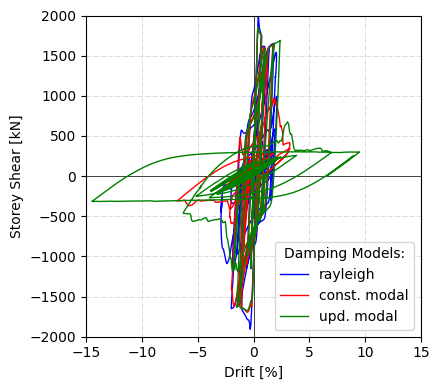

In [244]:
# plot the ground floor hysteresis
fig, ax = plt.subplots(1, figsize=(4.5, 4))

y_lim = 2000

colours = ["b", "r", "g"]
ax.axhline(0, color="k", lw=0.5)
ax.axvline(0, color="k", lw=0.5)
for model_tag, colour in zip(model_responses.keys(), colours):
    mr = model_responses[model_tag]["3.5"]
    ax.plot(mr["drift"][1] * 100, mr["vs"][1] / 1000, color=colour, lw=1, label=f"{model_tag}")

ax.grid(True, which="major", ls="-.", color="0.8", linewidth="0.5")
ax.legend(title="Damping Models:", loc="lower right")
ax.set_xlim(-15, 15)
ax.set_ylim(-2000, 2000)
ax.set_xlabel("Drift [%]")
ax.set_ylabel("Storey Shear [kN]")

fig.tight_layout()
fig.savefig(FIGURE_DST / "first_floor_hysteresis_sf3500.png", dpi=300)

## Profiles of Maximum Values

In [251]:
model_maximums = {}
for model_tag, model_response in model_responses.items():
    all_record_maximums = {}
    for record_tag, record_response in model_response.items():
        record_maximums = {}
        record_maximums["disp"] = np.array([max(abs(d)) for d in record_response["disp"].values()])
        record_maximums["drift"] = np.array([max(abs(d)) for d in record_response["drift"].values()])
        record_maximums["acc"] = np.array([max(abs(d["mean"])) for d in record_response["acc"].values()])
        record_maximums["vs"] = np.array([max(abs(vs)) for vs in record_response["vs"].values()])
        record_maximums["vd"] = np.array([max(abs(vd)) for vd in record_response["vd"].values()])
        
        all_record_maximums[record_tag] = record_maximums
    model_maximums[model_tag] = all_record_maximums

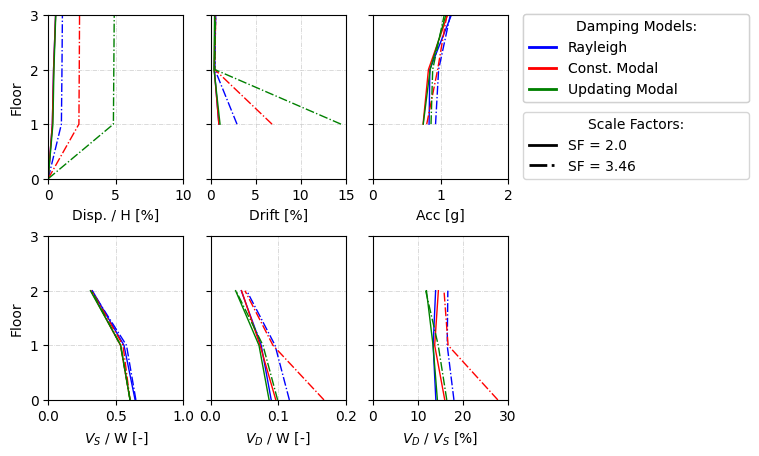

In [256]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(8, 5))
axs = [axs[0,0], axs[0,1], axs[0,2], axs[1,0], axs[1,1], axs[1,2]]

y_lim = 3
storeys = [1, 2, 3]
storeys_0 = [0, 1, 2]
levels = [0, 1, 2, 3]
model_colours = ["b", "r", "g"]
records = ["2.0", "3.5"]
record_lss = ["-", "-."]

for (model_tag, mr), colour in  zip(model_responses.items(), model_colours):
    for rec, line_style in zip(records, record_lss):
        mm = model_maximums[model_tag][rec]
        axs[0].plot(np.append([0], mm["disp"]) / building_height * 100, levels, lw=1, color=colour, ls=line_style)
        axs[1].plot(mm["drift"] * 100, storeys, lw=1, color=colour, ls=line_style)
        axs[2].plot(mm["acc"] / 9810, storeys, lw=1, color=colour, ls=line_style)
        axs[3].plot(mm["vs"] / building_weight, storeys_0, lw=1, color=colour, ls=line_style)  # in [g]
        axs[4].plot(mm["vd"] / building_weight, storeys_0, lw=1, color=colour, ls=line_style)  # in [g]
        axs[5].plot(mm["vd"] / mm["vs"] * 100, storeys_0, lw=1, color=colour, ls=line_style)  # in [g]

y_ticks = [0, 1, 2, 3]

axs[0].set_xlabel("Disp. / H [%]")
axs[0].set_ylabel("Floor")
axs[0].set_xticks([0, 5.0, 10.0])
axs[0].set_xlim(0, 10)

axs[1].set_xlabel("Drift [%]")
axs[1].set_xticks([0, 5.0, 10.0, 15.0])
axs[1].set_xlim(0, 15)

axs[2].set_xlabel("Acc [g]")
axs[2].set_xticks([0, 1.0, 2.0])
axs[2].set_xlim(0, 2)

axs[3].set_xlabel("$V_S$ / W [-]")
axs[3].set_xticks([0, 0.5, 1.0])
axs[3].set_xlim(0, 1.0)
axs[3].set_ylabel("Floor")

axs[4].set_xlabel("$V_D$ / W [-]")
axs[4].set_xticks([0, 0.1, 0.2])
axs[4].set_xlim(0, 0.2)

axs[5].set_xlabel("$V_D$ / $V_S$ [%]")
axs[5].set_xticks([0, 10, 20, 30])
axs[5].set_xlim(0, 30)


for ax, letter in zip(axs, ["A", "B", "C", "D", "E", "F"]):
    ax.grid(True, which="major", ls="-.", color="0.8", linewidth="0.5")
    ax.set_yticks(y_ticks)
    ax.set_ylim(0, y_lim)
    # ax.annotate(f"({letter})", (38.2, -900))

# Defining the legend
# 1. Define the specifications for your desired legend entries
legend_specs = [
    {'label': 'Rayleigh', 'color': 'blue', 'style': 'solid', 'marker': 'None'},
    {'label': 'Const. Modal', 'color': 'red', 'style': 'solid', 'marker': 'None'},
    {'label': 'Updating Modal', 'color': 'green', 'style': 'solid', 'marker': 'None'},
    {'label': 'SF = 2.0', 'color': 'k', 'style': '-', 'marker': 'None'},
    {'label': 'SF = 3.46', 'color': 'k', 'style': '-.', 'marker': 'None'},
]

# 2. Manually create the artists and their labels for the legend
# The artists list holds the visual elements (lines/patches)
# The labels list holds the corresponding text descriptions
artists = []
labels = []

for spec in legend_specs:
    labels.append(spec['label'])

    # Create a Line2D artist (for lines, markers, etc.)
    artist = Line2D(
        [0], [0], # Dummy data points
        color=spec['color'],
        linestyle=spec.get('style', 'solid'),
        marker=spec.get('marker', 'None'),
        lw=2 # Line width
    )

    artists.append(artist)

# 3. Generate the legend using the custom artists and labels
dm_legend = fig.legend(artists[0:3], labels[0:3], title="Damping Models:", loc="upper left", 
                       bbox_to_anchor=(0.71, 0.695, 0.3, 0.2),  # (x, y, w, h)
                       bbox_transform=fig.transFigure,
                       mode="expand",
                       frameon=True) 
fig.add_artist(dm_legend)
dm_legend.get_frame().set_clip_on(True)

sf_legend = fig.legend(artists[3:], labels[3:], title="Scale Factors:", loc="upper left", 
                       bbox_to_anchor=(0.71, 0.5, 0.3, 0.2),  # (x, y, w, h)
                       bbox_transform=fig.transFigure,
                       mode="expand",
                       frameon=True)

for l in [dm_legend, sf_legend]:
    lt = l.get_title()
    lt.set_ha("left")

# adjusting layout
fig.subplots_adjust(right=0.7, hspace=0.35)
fig.set_tight_layout(False) 
fig.set_constrained_layout(False)

fig.savefig(FIGURE_DST / "comparison_of_storey_maximums.png", dpi=300)

## Free Vibration after NLTHA

rayleigh 0.5
rayleigh 3.5
const. modal 0.5
const. modal 3.5
upd. modal 0.5
upd. modal 3.5


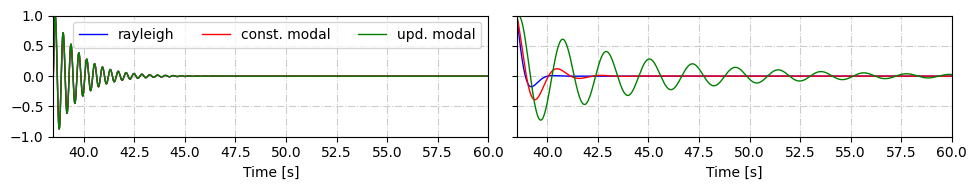

In [303]:
# plot the roof displacement of the damping models
colours = ["b", "r", "g"]
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,2))
t_start_fv = 38.5
t_end = 60
for model_tag, colour in zip(list(model_responses.keys()), colours):
    mr = model_responses[model_tag]
    ii = 0
    for record_tag, rr in mr.items():
        if record_tag not in ["0.5", "3.5"]:
            continue
        print(model_tag, record_tag)
        # scale the values based on the value at the start of free vibration. t = 38.5s
        idx_fv = np.where(rr["time"] > t_start_fv)[0][0]    # after this point we have free vibration
        residual_disp = rr["disp"][3][-1]                   # assumes at end the system comes to rest (or close to)
        roof_disp_fv = np.array(rr["disp"][3][idx_fv:]) - residual_disp     # residual corrected
        scaled_roof_disp = roof_disp_fv / np.max(np.abs(roof_disp_fv))

        axs[ii].plot(rr["time"][idx_fv:], scaled_roof_disp, color=colour, lw=1.0, label=f"{model_tag}")
        ii += 1

h, l = axs[0].get_legend_handles_labels()
for ax in axs:
    ax.set_xlim(t_start_fv,t_end)
    ax.set_ylim(-1, 1)
    ax.grid(True, color="0.8", ls="-.")
    ax.set_xlabel("Time [s]")

axs[0].legend(h, l, loc="upper right", ncols=3)
fig.subplots_adjust(top=0.75)
fig.tight_layout()
fig.savefig(FIGURE_DST / "normalised_free_vibration_comparison.png", dpi=300)



In [283]:
# calculate the observed damping ratio during the free vibration of the structure after damage.
final_damping_ratios = {}
for model_tag, mr in model_responses.items():
    record_responses = {}
    for record_tag, rr in mr.items():
        if record_tag not in ["0.5", "3.5"]:
            continue

        idx_fv = np.where(rr["time"] > 39)[0][0]    # after this point we have free vibration
        roof_disp_fv = np.array(rr["disp"][3][idx_fv:])
        
        # calculate the damping ratios
        start_peak = 1
        end_peak = 2
        local_maxs = argrelextrema(roof_disp_fv, np.greater)
        total_peaks = len(local_maxs[0])

        residual_disp = roof_disp_fv[-1] # approximated as last point. assumes all motion damped out

        relative_roof_disp = roof_disp_fv - residual_disp

        if start_peak >= total_peaks:
            record_responses[record_tag] = {"delta": np.nan,
                                            "ksi": np.nan}
            continue
        U1 = relative_roof_disp[local_maxs[0][start_peak]]
        Un = relative_roof_disp[local_maxs[0][end_peak]]

        n_oscillations = end_peak - start_peak

        delta = 1 / n_oscillations * np.log(U1 / Un)
        observed_ksi = delta / np.sqrt(4 * np.pi ** 2 + delta ** 2)

        record_responses[record_tag] = {"delta": delta,
                                        "ksi": observed_ksi,
                                        "residual_disp": residual_disp}

    final_damping_ratios[model_tag] = record_responses

print("Observed Damping Ratios:")
for model_tag, mr in final_damping_ratios.items():
    for record_tag, rr in mr.items():
        print(f"{model_tag:<20}| SF = {record_tag:<6}| residual disp = {rr["residual_disp"]:<10.4f}| damping = {rr['ksi']:.4f}")

Observed Damping Ratios:
rayleigh            | SF = 0.5   | residual disp = -0.0000   | damping = 0.0500
rayleigh            | SF = 3.5   | residual disp = 0.7660    | damping = 0.1105
const. modal        | SF = 0.5   | residual disp = -0.0000   | damping = 0.0500
const. modal        | SF = 3.5   | residual disp = -41.6702  | damping = 0.3481
upd. modal          | SF = 0.5   | residual disp = -0.0000   | damping = 0.0500
upd. modal          | SF = 3.5   | residual disp = -23.7213  | damping = 0.0574


## Fragility Curves

In [ ]:

model_folders =  {
    "R_01": "3s_cbf_dc2_41_rayleigh_initial",
    "CM_01": "3s_cbf_dc2_41_modal_12",
    "UM_01": "3s_cbf_dc2_41_modal_12_updating",
    "R_02": "model_02_rayleigh_initial",
    "CM_02": "model_02_modal_12",
    "UM_02": "model_02_modal_12_updating",
    }

analysis_folder = "ida_SA"

In [ ]:
# post process the ida results
for k, v in model_folders.items():
    ida_folder = ROOT / v / analysis_folder
    with open(ida_folder / "ida_results.pickle", "rb") as file:
        ida_results = pickle.load(file)

    process_ida_results(ida_results.values(), ida_folder, [0], ["drift"], 
                        record_ids=ida_results.keys(), collapse_fragility=True)

In [ ]:
# Get fragilities
collapse_fragilities = {}
for k, v in model_folders.items():
    ida_folder = ROOT / v / analysis_folder
    with open(ida_folder / "collapse_fragility.json", "r") as file:
        collapse_fragilities[k] = FragilityCurve(**json.load(file))

R_01      | median =    6.176| beta =    0.583
CM_01     | median =    5.149| beta =    0.583
UM_01     | median =    3.306| beta =    0.546
R_02      | median =    6.358| beta =    0.587
CM_02     | median =    5.750| beta =    0.610
UM_02     | median =    3.219| beta =    0.551


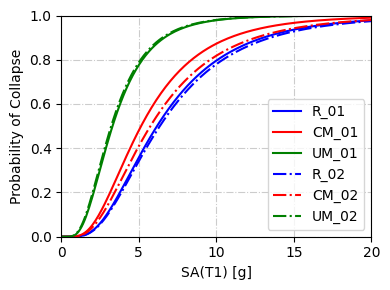

In [27]:
# plot the results
fig = plt.figure(figsize=(4,3))
ax = plt.gca()

gravity = 9810
x_min = 0.001 * gravity
x_max = 20 * gravity
n = 200

for k, fc in collapse_fragilities.items():
    c = fc.curve(x_min, x_max, n)
    print(f"{k:<10}| median = {fc.median / gravity:>8.3f}| beta = {fc.dispersion:>8.3f}")
    
    dm = k.split("_")[0]
    dia = k.split("_")[1]

    if dm == "R": colour = "b"
    elif dm == "CM": colour = "r"
    elif dm == "UM": colour = "g"

    if dia == "01": line = "-"
    elif dia == "02": line = "-."

    ax.plot(c[:,0] / gravity, c[:,1], ls=line, color=colour, label=k)

ax.legend()
ax.set_xlim(0, x_max / gravity)
ax.set_ylim(0, 1.0)
ax.grid(True, which="major", ls="-.", color="0.8")
ax.set_xlabel("SA(T1) [g]")
ax.set_ylabel("Probability of Collapse")

fig.tight_layout()
fig.savefig(FIGURE_DST / "damping_model_fragility_curves.png", dpi=300)